# Gesture Recognition

**Problem Statement**

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

    Gesture     - Corresponding Action
    Thumbs Up   - Increase the volume.
    Thumbs Down - Decrease the volume.
    Left Swipe  - Jump backwards 10 seconds.
    Right Swipe - Jump forward 10 seconds.
    Stop        - Pause the movie.
    
Each video is a sequence of 30 frames (or images).

**Objectives:**

**Generator:** The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

**Model:** Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

**Write up:** This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
#rm -rf ~/.local/share/Trash/*

#### Import Libraries

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import abc

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from keras.layers.recurrent import LSTM

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

**Function** to plot the training/validation accuracies/losses.

In [5]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [6]:
project_folder='/home/datasets/Project_data'

## Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
                            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    # Train Model
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Modelling

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1

    Batch Size - 32
    Frames to Sample - 30
    Image Size - 160 x 160 

In [14]:
class ModelConv3D_1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
conv_3d1=ModelConv3D_1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=32,num_epochs=15)
conv_3d1_model=conv_3d1.define_model(filtersize=(3,3,3),dense_neurons=128,dropout=0.25)
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

2022-05-18 04:59:29.614938: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-18 04:59:29.614998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [12]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1949509


/tmp/ipykernel_419/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/15


2022-05-18 04:59:46.801109: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.4456 - categorical_accuracy: 0.4585
Epoch 00001: val_loss improved from inf to 1.94150, saving model to model_init_2022-05-1804_59_37.378572/model-00001-1.44557-0.45852-1.94150-0.28000.h5
21/21 [==============================] - 195s 9s/step - loss: 1.4456 - categorical_accuracy: 0.4585 - val_loss: 1.9415 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.8236 - categorical_accuracy: 0.6878
Epoch 00002: val_loss did not improve from 1.94150
21/21 [==============================] - 193s 10s/step - loss: 0.8236 - categorical_accuracy: 0.6878 - val_loss: 4.2957 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.4963 - categorical_accuracy: 0.8190
Epoch 00003: val_loss did not improve from 1.94150
21/21 [==============================] - 189s 9s/step - loss: 0.4963 - categorical_accuracy: 0.8190 - va

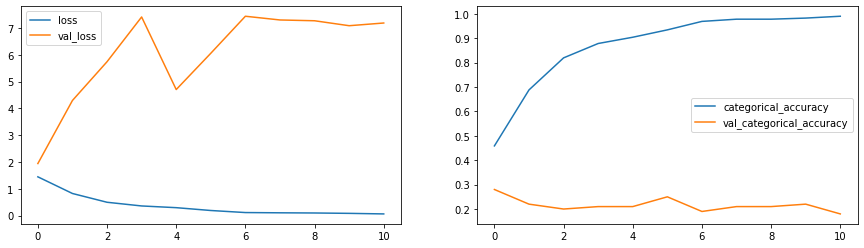

In [13]:
plot(history_model1)

#### Result
    Total params: 1,947,525
    Train Accuracy - 98%
    Validation Accuracy - 11%
    
The validation accuracy is not increasing and staying within 20% even though the train accuracy is increasing every epochs. Seems it's not getting trained.

In next model let's remove batch normalisation() as its already normalised in generator.

### Model 2

    Same as Model 1, only batch normalisations have been removed.

In [9]:
class ModelConv3D_2(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        #model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        #model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
conv_3d2=ModelConv3D_2()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=30,batch_size=32,num_epochs=15)
conv_3d2_model=conv_3d2.define_model(filtersize=(3,3,3),dense_neurons=128,dropout=0.25)
conv_3d2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 30, 160, 160, 16)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 15, 80, 80, 32)    0         
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 7, 40, 40, 32)    0         
 3D)                                                  

In [16]:
print("Total Params:", conv_3d2_model.count_params())
history_model2 = conv_3d2.train_model(conv_3d2_model)

Total Params: 1947525


/tmp/ipykernel_419/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.6318 - categorical_accuracy: 0.2006
Epoch 00001: val_loss improved from inf to 1.55579, saving model to model_init_2022-05-1805_39_09.736477/model-00001-1.63179-0.20060-1.55579-0.23000.h5
21/21 [==============================] - 191s 9s/step - loss: 1.6318 - categorical_accuracy: 0.2006 - val_loss: 1.5558 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.5066 - categorical_accuracy: 0.2700
Epoch 00002: val_loss improved from 1.55579 to 1.28998, saving model to model_init_2022-05-1805_39_09.736477/model-00002-1.50660-0.26998-1.28998-0.41000.h5
21/21 [==============================] - 195s 10s/step - loss: 1.5066 - categorical_accuracy: 0.2700 - val_loss: 1.2900 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.3563 - categorical_accuracy: 0.3876
Epoch 00003: val_loss improved from 1.2

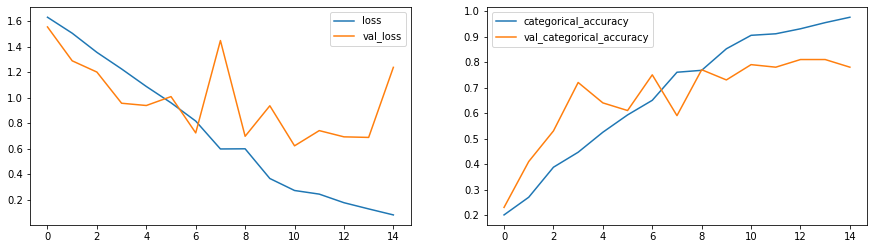

In [17]:
plot(history_model2)

#### Results
    Total params: 1,947,525
    Train Accuracy - 97%
    Validation Accuracy - 78%
    
    Performance across every epoch has improved as per expectation. The validation accuracy is also increasing with every epoch. However the model is overfitting.

### Model 3

    Lets' experiment by reducing the image size, and frames per sample(taking alternate frames), and increase batch size. Also to address the issue of overfitting lets remove on layer from the model(1st layer of 16 neurons)
    
    Batch Size - 64
    frames per sample - 16
    image size - 100 x 100
    Removed one hidden layer

In [10]:
class ModelConv3D_3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_3d3=ModelConv3D_3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=100,image_width=100)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=15)
conv_3d3_model=conv_3d3.define_model(filtersize=(3,3,3),dense_neurons=128,dropout=0.25)
conv_3d3_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 activation_13 (Activation)  (None, 8, 50, 50, 32)     0         
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 4, 25, 25, 32)    0         
 g3D)                                                 

In [22]:
print("Total Params:", conv_3d3_model.count_params())
history_model3 = conv_3d3.train_model(conv_3d3_model)

Total Params: 898949


/tmp/ipykernel_419/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.6152 - categorical_accuracy: 0.2051
Epoch 00001: val_loss improved from inf to 1.59090, saving model to model_init_2022-05-1806_51_12.047202/model-00001-1.61518-0.20513-1.59090-0.25000.h5
11/11 [==============================] - 95s 9s/step - loss: 1.6152 - categorical_accuracy: 0.2051 - val_loss: 1.5909 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.5592 - categorical_accuracy: 0.2097
Epoch 00002: val_loss improved from 1.59090 to 1.40075, saving model to model_init_2022-05-1806_51_12.047202/model-00002-1.55919-0.20965-1.40075-0.29000.h5
11/11 [==============================] - 90s 9s/step - loss: 1.5592 - categorical_accuracy: 0.2097 - val_loss: 1.4008 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.4652 - categorical_accuracy: 0.3605
Epoch 00003: val_loss improved from 1.4007

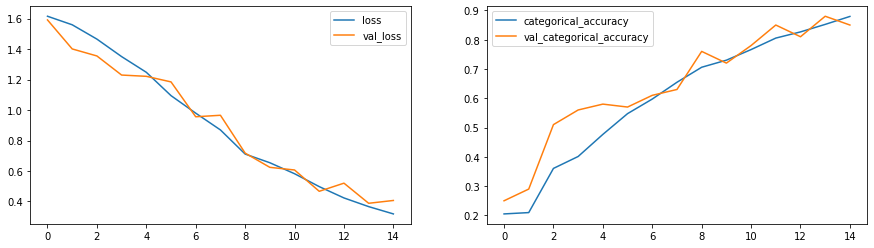

In [23]:
plot(history_model3)

#### Results
    Total params: 898,949
    Train Accuracy - 87%
    Validation Accuracy - 85%
    
We got model performing good and the gap between train and val accuracy is also lower. Total parameters also reduced with removal of one hidden layer.

### Model 4

    Let's try decreasing the image size further and check the performance keeping other configuration same as model 3.
    
    Batch Size - 64
    frames per sample - 16
    image size - 80 x 80

In [25]:
conv_3d4=ModelConv3D_3()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=80,image_width=80)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=15)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=128,dropout=0.25)
conv_3d4_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 activation_16 (Activation)  (None, 16, 80, 80, 16)    0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 40, 40, 32)     13856     
                                                                 
 activation_17 (Activation)  (None, 8, 40, 40, 32)     0         
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 4, 20, 20, 32)    0         
 g3D)                                                 

In [26]:
print("Total Params:", conv_3d4_model.count_params())
history_model4 = conv_3d4.train_model(conv_3d4_model)

Total Params: 718725


/tmp/ipykernel_419/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.6177 - categorical_accuracy: 0.1946
Epoch 00001: val_loss improved from inf to 1.60367, saving model to model_init_2022-05-1807_17_02.058078/model-00001-1.61774-0.19457-1.60367-0.18000.h5
11/11 [==============================] - 99s 10s/step - loss: 1.6177 - categorical_accuracy: 0.1946 - val_loss: 1.6037 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.6166 - categorical_accuracy: 0.2142
Epoch 00002: val_loss did not improve from 1.60367
11/11 [==============================] - 95s 9s/step - loss: 1.6166 - categorical_accuracy: 0.2142 - val_loss: 1.6090 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.5964 - categorical_accuracy: 0.2459
Epoch 00003: val_loss improved from 1.60367 to 1.54276, saving model to model_init_2022-05-1807_17_02.058078/model-00003-1.59640-0.24585-1.54276-0

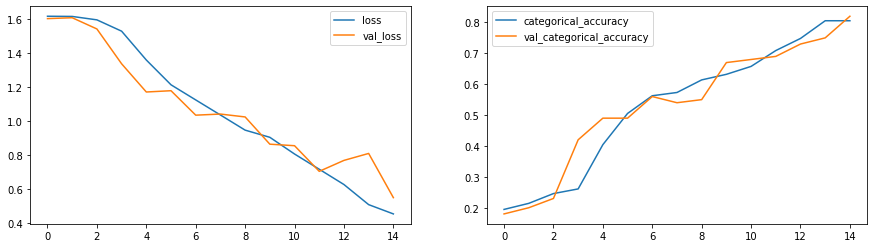

In [27]:
plot(history_model4)

#### Results
    Total params: 718,725
    Train Accuracy - 80%
    Validation Accuracy - 82%
    
    The performace of the model didnt improve much.

### Model 5

    Lets not increase the batch size to 128.

In [28]:
conv_3d5=ModelConv3D_3()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=80,image_width=80)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=128,num_epochs=25)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=128,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 activation_20 (Activation)  (None, 16, 80, 80, 16)    0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 40, 40, 32)     13856     
                                                                 
 activation_21 (Activation)  (None, 8, 40, 40, 32)     0         
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 4, 20, 20, 32)    0         
 g3D)                                                 

In [29]:
print("Total Params:", conv_3d5_model.count_params())
history_model5 = conv_3d5.train_model(conv_3d5_model)

Total Params: 718725


/tmp/ipykernel_419/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25
6/6 [==============================] - ETA: 0s - loss: 1.6058 - categorical_accuracy: 0.2081 
Epoch 00001: val_loss improved from inf to 1.57058, saving model to model_init_2022-05-1807_42_18.241128/model-00001-1.60579-0.20814-1.57058-0.23000.h5
6/6 [==============================] - 93s 18s/step - loss: 1.6058 - categorical_accuracy: 0.2081 - val_loss: 1.5706 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
6/6 [==============================] - ETA: 0s - loss: 1.5500 - categorical_accuracy: 0.2202 
Epoch 00002: val_loss improved from 1.57058 to 1.40004, saving model to model_init_2022-05-1807_42_18.241128/model-00002-1.54999-0.22021-1.40004-0.26000.h5
6/6 [==============================] - 96s 19s/step - loss: 1.5500 - categorical_accuracy: 0.2202 - val_loss: 1.4000 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/25
6/6 [==============================] - ETA: 0s - loss: 1.4281 - categorical_accuracy: 0.3107 
Epoch 00003: val_loss improved from 1.40004 to 

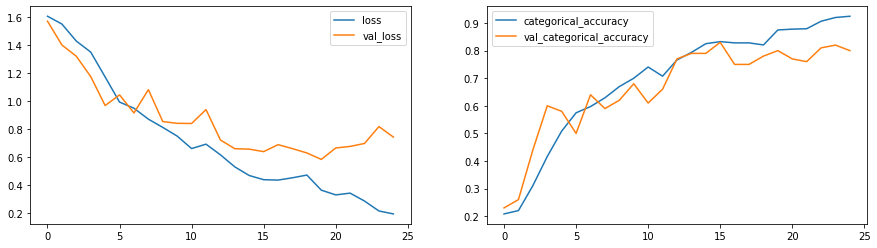

In [30]:
plot(history_model5)

#### Results
    Total params: 718,725
    Train Accuracy - 87%
    Validation Accuracy - 80%
    
    There is not much improvement in performance. Also the gap between train and val accuracy is more.

### Model 6 - Best Model

    As there was not much accuracy improvement with increasing batch size. Let's consider the older model with batch size of 32 only.
    In order to reduce parameter's lets lower the dense neurons to 64 from 128.

In [18]:
conv_3d6=ModelConv3D_3()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=80,image_width=80)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=25)
conv_3d6_model=conv_3d6.define_model(filtersize=(3,3,3),dense_neurons=64,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 activation_14 (Activation)  (None, 16, 80, 80, 16)    0         
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_15 (Conv3D)          (None, 8, 40, 40, 32)     13856     
                                                                 
 activation_15 (Activation)  (None, 8, 40, 40, 32)     0         
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 4, 20, 20, 32)    0         
 g3D)                                                 

In [19]:
print("Total Params:", conv_3d6_model.count_params())
history_model6 = conv_3d6.train_model(conv_3d6_model)

Total Params: 501189


/tmp/ipykernel_373/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6147 - categorical_accuracy: 0.1961
Epoch 00001: val_loss improved from inf to 1.59439, saving model to model_init_2022-05-1809_17_10.622064/model-00001-1.61472-0.19608-1.59439-0.23000.h5
21/21 [==============================] - 85s 4s/step - loss: 1.6147 - categorical_accuracy: 0.1961 - val_loss: 1.5944 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.5690 - categorical_accuracy: 0.2247
Epoch 00002: val_loss improved from 1.59439 to 1.38727, saving model to model_init_2022-05-1809_17_10.622064/model-00002-1.56902-0.22474-1.38727-0.24000.h5
21/21 [==============================] - 82s 4s/step - loss: 1.5690 - categorical_accuracy: 0.2247 - val_loss: 1.3873 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.5117 - categorical_accuracy: 0.3258
Epoch 00003: val_loss did not improve from

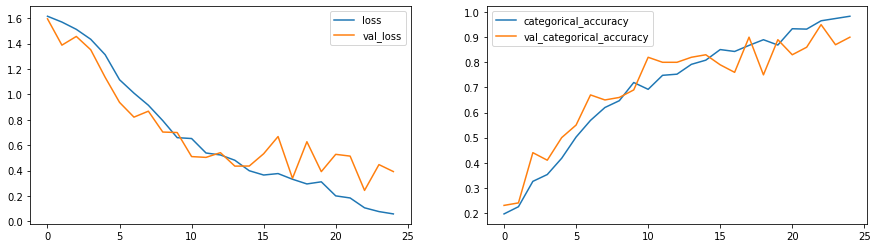

In [20]:
plot(history_model6)

#### Results
    Total params: 501,189
    Train Accuracy - 96%
    Validation Accuracy - 95%
    
    The model did really well with high accuracy of 96% train and 95% validation accuracy. Also the parameter count is comparatively low.

### Model 7

Let's try to reduce the parameter's further and check if the accuracy still can be maintained.
Filter size = (2,2,2)

In [38]:
conv_3d7=ModelConv3D_3()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=80,image_width=80)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(filtersize=(2,2,2),dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 16, 80, 80, 16)    400       
                                                                 
 activation_18 (Activation)  (None, 16, 80, 80, 16)    0         
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 8, 40, 40, 32)     4128      
                                                                 
 activation_19 (Activation)  (None, 8, 40, 40, 32)     0         
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 4, 20, 20, 32)    0         
 g3D)                                                

In [39]:
print("Total Params:", conv_3d7_model.count_params())
history_model7 = conv_3d7.train_model(conv_3d7_model)

Total Params: 295989


/tmp/ipykernel_373/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6091 - categorical_accuracy: 0.2066
Epoch 00001: val_loss improved from inf to 1.58228, saving model to model_init_2022-05-1811_35_33.999631/model-00001-1.60907-0.20664-1.58228-0.25000.h5
21/21 [==============================] - 88s 4s/step - loss: 1.6091 - categorical_accuracy: 0.2066 - val_loss: 1.5823 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.5972 - categorical_accuracy: 0.2368
Epoch 00002: val_loss improved from 1.58228 to 1.51855, saving model to model_init_2022-05-1811_35_33.999631/model-00002-1.59722-0.23680-1.51855-0.27000.h5
21/21 [==============================] - 87s 4s/step - loss: 1.5972 - categorical_accuracy: 0.2368 - val_loss: 1.5186 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.4769 - categorical_accuracy: 0.3318
Epoch 00003: val_loss improved from 1.5185

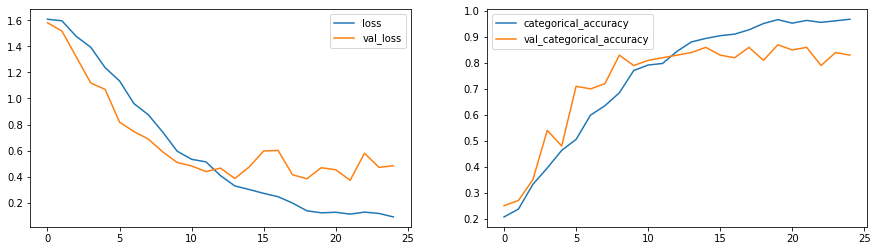

In [40]:
plot(history_model7)

#### Results
    Total params: 295,989
    Train Accuracy - 96%
    Validation Accuracy - 86%
    
    Although the parameters reduced, however the validation accuracy dropped.

### Model 8

    Let's experiment with same configuration as the best model so far(model 6) and only changing the activation function to elu instead of relu.

In [41]:
class ModelConv3D_4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='elu'))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='elu'))
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [42]:
conv_3d8=ModelConv3D_4()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=80,image_width=80)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=25)
conv_3d8_model=conv_3d8.define_model(filtersize=(3,3,3),dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 activation_22 (Activation)  (None, 16, 80, 80, 16)    0         
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_23 (Conv3D)          (None, 8, 40, 40, 32)     13856     
                                                                 
 activation_23 (Activation)  (None, 8, 40, 40, 32)     0         
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 4, 20, 20, 32)    0         
 g3D)                                                

In [43]:
print("Total Params:", conv_3d8_model.count_params())
history_model8 = conv_3d8.train_model(conv_3d8_model)

Total Params: 501189


/tmp/ipykernel_373/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6901 - categorical_accuracy: 0.2187
Epoch 00001: val_loss improved from inf to 1.53371, saving model to model_init_2022-05-1812_11_59.738303/model-00001-1.69012-0.21870-1.53371-0.23000.h5
21/21 [==============================] - 90s 4s/step - loss: 1.6901 - categorical_accuracy: 0.2187 - val_loss: 1.5337 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.4055 - categorical_accuracy: 0.3786
Epoch 00002: val_loss improved from 1.53371 to 1.16901, saving model to model_init_2022-05-1812_11_59.738303/model-00002-1.40554-0.37858-1.16901-0.49000.h5
21/21 [==============================] - 87s 4s/step - loss: 1.4055 - categorical_accuracy: 0.3786 - val_loss: 1.1690 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.0579 - categorical_accuracy: 0.5762
Epoch 00003: val_loss improved from 1.1690

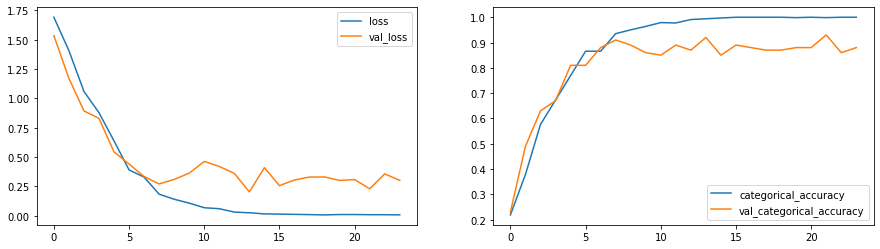

In [44]:
plot(history_model8)

#### Results
    Total params: 501,189
    Train Accuracy - 99%
    Validation Accuracy - 92%
    
    Theres not much improvement in accuracy. The training stopped early as there wasnt improvement. Thank's to early stopping.

### Model 9

    So far model 6 has been the best. so let's try increasing the batch size for maximum gpu utilisation and see if the performance is still maintained.
    
    Batch size = 64

In [11]:
conv_3d9=ModelConv3D_3()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=80,image_width=80)
conv_3d9.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=25)
conv_3d9_model=conv_3d9.define_model(filtersize=(3,3,3),dense_neurons=64,dropout=0.25)
conv_3d9_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 80, 80, 16)    1312      
                                                                 
 activation (Activation)     (None, 16, 80, 80, 16)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 40, 40, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 40, 40, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 8, 40, 40, 32)     0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 20, 20, 32)    0         
 3D)                                                    

2022-05-18 13:13:59.815496: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-18 13:13:59.815555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:41:00.0, compute capability: 7.5


In [12]:
print("Total Params:", conv_3d9_model.count_params())
history_model9 = conv_3d9.train_model(conv_3d9_model)

Total Params: 501189


/tmp/ipykernel_389/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25


2022-05-18 13:14:16.972635: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.6171 - categorical_accuracy: 0.1795
Epoch 00001: val_loss improved from inf to 1.60801, saving model to model_init_2022-05-1813_14_08.199393/model-00001-1.61711-0.17949-1.60801-0.23000.h5
11/11 [==============================] - 91s 9s/step - loss: 1.6171 - categorical_accuracy: 0.1795 - val_loss: 1.6080 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.6078 - categorical_accuracy: 0.1855
Epoch 00002: val_loss improved from 1.60801 to 1.59413, saving model to model_init_2022-05-1813_14_08.199393/model-00002-1.60778-0.18552-1.59413-0.21000.h5
11/11 [==============================] - 86s 9s/step - loss: 1.6078 - categorical_accuracy: 0.1855 - val_loss: 1.5941 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 1.5939 - categorical_accuracy: 0.2127
Epoch 00003: val_loss improved from 1.59413 to 1.5640

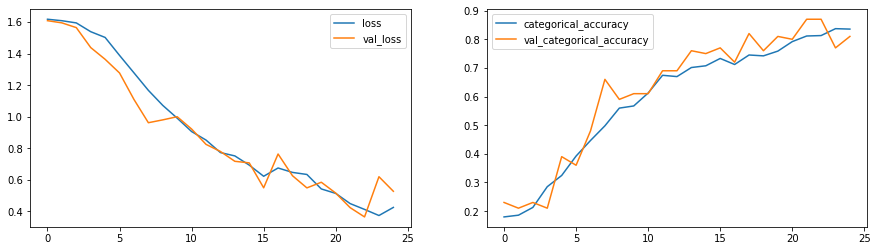

In [13]:
plot(history_model9)

#### Results
    Total params: 501,189
    Train Accuracy - 83%
    Validation Accuracy - 81%
    
    With increase in batch size the training time has reduced but the accuracy has reduced.

### Model 10

    Although the accuracy is reducing let's check what's the max batch size we can go with.
    Batch size = 256

In [25]:
conv_3d10=ModelConv3D_3()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=80,image_width=80)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=256,num_epochs=35)
conv_3d10_model=conv_3d10.define_model(filtersize=(3,3,3),dense_neurons=64,dropout=0.25)
conv_3d10_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 activation_24 (Activation)  (None, 16, 80, 80, 16)    0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 40, 40, 32)     13856     
                                                                 
 activation_25 (Activation)  (None, 8, 40, 40, 32)     0         
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 4, 20, 20, 32)    0         
 g3D)                                                 

In [26]:
print("Total Params:", conv_3d10_model.count_params())
history_model10 = conv_3d10.train_model(conv_3d10_model)

Total Params: 501189


/tmp/ipykernel_389/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/35
3/3 [==============================] - ETA: 0s - loss: 1.6056 - categorical_accuracy: 0.1825 
Epoch 00001: val_loss improved from inf to 1.59732, saving model to model_init_2022-05-1814_32_20.064725/model-00001-1.60563-0.18250-1.59732-0.18000.h5
3/3 [==============================] - 77s 38s/step - loss: 1.6056 - categorical_accuracy: 0.1825 - val_loss: 1.5973 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/35
3/3 [==============================] - ETA: 0s - loss: 1.6021 - categorical_accuracy: 0.2232 
Epoch 00002: val_loss improved from 1.59732 to 1.58516, saving model to model_init_2022-05-1814_32_20.064725/model-00002-1.60212-0.22323-1.58516-0.23000.h5
3/3 [==============================] - 75s 37s/step - loss: 1.6021 - categorical_accuracy: 0.2232 - val_loss: 1.5852 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/35
3/3 [==============================] - ETA: 0s - loss: 1.5958 - categorical_accuracy: 0.2278 
Epoch 00003: val_loss did not improve from 1.58

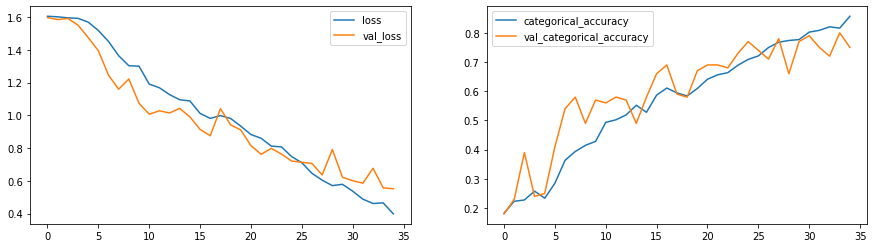

In [27]:
plot(history_model10)

#### Results
    Total params: 501,189
    Train Accuracy - 81%
    Validation Accuracy - 80%
    
    The accuracy is still lower.

### Model 11

    Increasing the batch size to 512, to see if it's supported by GPU.

In [21]:
conv_3d11=ModelConv3D_3()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=80,image_width=80)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=512,num_epochs=20)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=64,dropout=0.25)
conv_3d11_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 activation_16 (Activation)  (None, 16, 80, 80, 16)    0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 40, 40, 32)     13856     
                                                                 
 activation_17 (Activation)  (None, 8, 40, 40, 32)     0         
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 4, 20, 20, 32)    0         
 g3D)                                                 

In [22]:
print("Total Params:", conv_3d11_model.count_params())
history_model11 = conv_3d11.train_model(conv_3d11_model)

Total Params: 501189


/tmp/ipykernel_389/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20


2022-05-18 14:07:11.881233: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.12GiB (rounded to 3355443200)requested by op sequential_4/max_pooling3d_16/MaxPool3D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-05-18 14:07:11.881347: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-05-18 14:07:11.881399: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 211, Chunks in use: 210. 52.8KiB allocated for chunks. 52.5KiB in use in bin. 16.9KiB client-requested in use in bin.
2022-05-18 14:07:11.881426: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 45, Chunks in use: 45. 22.5KiB allocated for chunks. 22.5KiB in use in bin. 22.5KiB client-requested in use in 

ResourceExhaustedError:  OOM when allocating tensor with shape[512,16,16,80,80] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_4/max_pooling3d_16/MaxPool3D
 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py:699)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_10494]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_4/max_pooling3d_16/MaxPool3D:
In[0] sequential_4/activation_16/Relu (defined at /usr/local/lib/python3.8/dist-packages/keras/backend.py:4867)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_389/521841621.py", line 2, in <module>
>>>     history_model11 = conv_3d11.train_model(conv_3d11_model)
>>> 
>>>   File "/tmp/ipykernel_389/958052542.py", line 125, in train_model
>>>     history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2016, in fit_generator
>>>     return self.fit(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py", line 699, in call
>>>     outputs = self.pool_function(
>>> 

***********_____*****________________****____*
2022-05-18 14:07:11.889216: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at cudnn_pooling_gpu.cc:49 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[512,16,16,80,80] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc


#### Results
    Total params: 501,189
    
    We get out of memory error. So, we can get batch size of 256, however the accuracy is lower. So lets keep the batch size to 32 so that we get higher accuracy.

### Model 12

Lets experiment by changing the architecture to conv2d + lstm

In [23]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=80,image_width=80)
rnn_cnn1.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_11 (TimeDi  (None, 16, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 16, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 20, 20, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 20, 20, 64)  

In [25]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model_rnn_1=rnn_cnn1.train_model(rnn_cnn1_model)

Total Params: 1000101


/tmp/ipykernel_373/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6153 - categorical_accuracy: 0.2066
Epoch 00001: val_loss improved from inf to 1.60953, saving model to model_init_2022-05-1809_52_36.905555/model-00001-1.61532-0.20664-1.60953-0.18000.h5
21/21 [==============================] - 90s 4s/step - loss: 1.6153 - categorical_accuracy: 0.2066 - val_loss: 1.6095 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.6081 - categorical_accuracy: 0.2157
Epoch 00002: val_loss improved from 1.60953 to 1.58635, saving model to model_init_2022-05-1809_52_36.905555/model-00002-1.60808-0.21569-1.58635-0.19000.h5
21/21 [==============================] - 86s 4s/step - loss: 1.6081 - categorical_accuracy: 0.2157 - val_loss: 1.5863 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.5324 - categorical_accuracy: 0.2896
Epoch 00003: val_loss improved from 1.5863

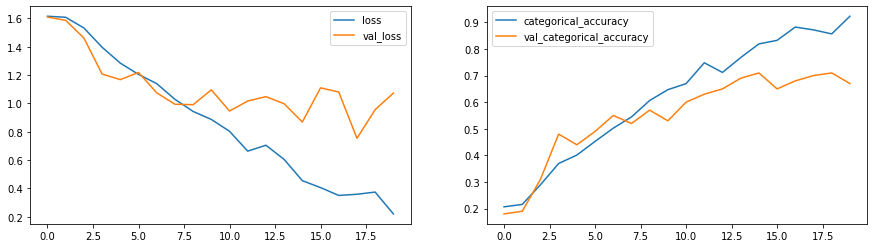

In [27]:
plot(history_model_rnn_1)

#### Results
    Total params: 1,000,101
    Train Accuracy - 87%
    Validation Accuracy - 70%
    
    The model is over fitting.

### Model 13

    Reducing the dence layer neurons from 128 to 64.

In [29]:
rnn_cnn2=RNNCNN1()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=80,image_width=80)
rnn_cnn2.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=64,dropout=0.5)
rnn_cnn2_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeDi  (None, 16, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 16, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 16, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 16, 20, 20, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 16, 20, 20, 64)  

In [30]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model_rnn_2 = rnn_cnn2.train_model(rnn_cnn2_model)

Total Params: 991525


/tmp/ipykernel_373/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6167 - categorical_accuracy: 0.2066
Epoch 00001: val_loss improved from inf to 1.60559, saving model to model_init_2022-05-1810_22_42.485897/model-00001-1.61672-0.20664-1.60559-0.24000.h5
21/21 [==============================] - 88s 4s/step - loss: 1.6167 - categorical_accuracy: 0.2066 - val_loss: 1.6056 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5859 - categorical_accuracy: 0.2398
Epoch 00002: val_loss improved from 1.60559 to 1.46842, saving model to model_init_2022-05-1810_22_42.485897/model-00002-1.58590-0.23982-1.46842-0.33000.h5
21/21 [==============================] - 86s 4s/step - loss: 1.5859 - categorical_accuracy: 0.2398 - val_loss: 1.4684 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.5452 - categorical_accuracy: 0.3017
Epoch 00003: val_loss improved from 1.4684

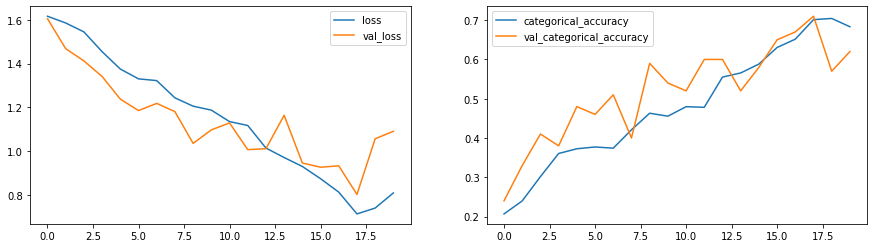

In [33]:
plot(history_model_rnn_2)

#### Results
    Total params: 991,525
    Train Accuracy - 70%
    Validation Accuracy - 71%
    
    The model accuracy is lower.

### Model 14

    Let's experiment with Conv2d + GRU architecture.

In [34]:
class RNNCNN3(ModelBuilder):
    
    def define_model(self,GRU_cells=64, dense_neurons=64,dropout=0.25):
        model = Sequential()   
        model.add(TimeDistributed(Conv2D(8, (3, 3),padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(GRU_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(5, activation='softmax'))

        optimiser = optimizers.Adam(lr=0.001)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
rnn_cnn3=RNNCNN3()
rnn_cnn3.initialize_path(project_folder)
rnn_cnn3.initialize_image_properties(image_height=80,image_width=80)
rnn_cnn3.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=20)
rnn_cnn3_model=rnn_cnn3.define_model(GRU_cells=64,dense_neurons=64,dropout=0.25)
rnn_cnn3_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_44 (TimeDi  (None, 16, 80, 80, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 16, 40, 40, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 16, 40, 40, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 16, 20, 20, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 16, 20, 20, 32) 

In [36]:
print("Total Params:", rnn_cnn3_model.count_params())
history_model_rnn_3 = rnn_cnn3.train_model(rnn_cnn3_model)

Total Params: 213845


/tmp/ipykernel_373/958052542.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6185 - categorical_accuracy: 0.1704
Epoch 00001: val_loss improved from inf to 1.60017, saving model to model_init_2022-05-1810_58_46.651817/model-00001-1.61852-0.17044-1.60017-0.23000.h5
21/21 [==============================] - 92s 4s/step - loss: 1.6185 - categorical_accuracy: 0.1704 - val_loss: 1.6002 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.6005 - categorical_accuracy: 0.2353
Epoch 00002: val_loss improved from 1.60017 to 1.57692, saving model to model_init_2022-05-1810_58_46.651817/model-00002-1.60055-0.23529-1.57692-0.22000.h5
21/21 [==============================] - 87s 4s/step - loss: 1.6005 - categorical_accuracy: 0.2353 - val_loss: 1.5769 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.5818 - categorical_accuracy: 0.2368
Epoch 00003: val_loss did not improve from

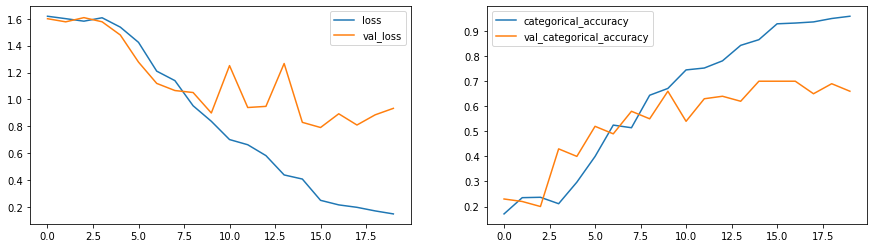

In [37]:
plot(history_model_rnn_3)

#### Results
    Total params: 213,845
    Train Accuracy - 95%
    Validation Accuracy - 66%
    
    The model is highly overfitting.

## Conclusion

After experimenting on various aspects like

    Image Size,
    Normalization,
    Image index,
    Batch Size,
    Activation Function,
    Filter size,
    Neuron counts and layers,
    Architectures - conv3d, conv2d+lstm, conv2d+gru
    
The best model (model 6) having below configuration.
    
    Architecture - Conv3D
    Image Size - 80x80
    Batch Size - 32
    Image Index - alternate with 16 frames per sample
    Activation function - relu
    Filter size - 3,3,3
    
    Training Accuracy - 96 %
    Validation Accuracy - 95 %
    Total params: 501,189